# PyOAE - Example calculation of the hypothetical maximum OAE efficiency ($\eta$max)

by Greg Pelletier, 01-Feb-2025

This notebook presents a new function "etamax" to calculate the hypothetical maximum OAE efficiency ($\eta$max) for an assumed alkalinity treatment addition ($\Delta$TA). The potential maximum CDR is also calculated with $\eta$max, and these two variables are related to each other as follows:

- $\eta$max = CDRpot / $\Delta$TA = the hypothetical maximum OAE efficiency "etamax", typically in the range of 0.7-0.9 (dimensionless)

where CDRpot is the hypothetical maximumum potential CDR corresponding to the OAE treatment.

Inputs to the "etamax" function are as follows:

- dTA = $\Delta$TA addition of alkalinity due to OAE (umol/kg)
- TA_ctl = control TA before OAE treatment (umol/kg)
- DIC_ctl = control DIC before OAE treatment (umol/kg)
- SiO3_ctl = control SiO3 (umol/kg)
- PO4_ctl = control PO4 at time before OAE treatment (umol/kg)
- Temp_ctl = control temperature ($^\circ$C)
- Sal_ctl = control salinity (psu)
- Pres_ctl = control pressure (dbar)

The "etamax" function calculates the following variables using PyCO2SYS:

- Step 1: Calculate pCO2 at control conditions (pCO2_ctl in uatm) using inputs of TA_ctl and DIC_ctl as inputs

- Step 2: Calculate DIC_eq, CDR_pot, and etamax using inputs of TA= TA_ctl + dTA and pCO2 at control conditions, defined as follows:
    - DIC_eq = PyCO2SYS calculation of DIC at equilibrium when input TA= TA_ctl + dTA and input pCO2= pCO2t_ctl
    - CDR_pot = DIC_eq - DIC_ctl = hypothetical maximum potential CDR (umol/kg)
    - etamax = CDR_pot / dTA = hypothetical maximum OAE efficiency, typically in the range of 0.7-0.9 (dimensionless)

The "etamax" function returns a data dictionary of outputs including etamax, CDR_pot, DIC_eq, and pCO2_ctl


## Import the d_dTA function from PyOAE

Next we will import the etamax function from PyOAE. This function performs teh steps described above.

First, uncomment and run one of the next two lines if PyOAE is not already installed. Use the first line if this is the first time installing PyOAE. Use the second line that includes "--upgrade" if PyOAE is already installed but needs to be updated to the latest version

In [6]:
# !pip install git+https://github.com/gjpelletier/PyOAE.git
# !pip install git+https://github.com/gjpelletier/PyOAE.git --upgrade

Next we import the etamax function from PyOAE

In [7]:
from PyOAE import etamax

## Import the other packages that are needed

In [8]:
import numpy as np
import PyCO2SYS as pyco2
import xarray as xr
import dask.array as da
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline
import time
import ncvue

## Define a matlab-style tic toc timer

We will use these tic and toc functions to measure the CPU time to perform the computations

In [9]:
def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )
    return

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

## Read the data for pre-industrial (1750) and current control conditions before OAE treatment (2010) 

In the next section we will read a netcdf file that contains the condtions in 1750 and 2010 for TA (umol/kg), DIC (umol/kg), SiO3 (umol/kg), PO4 (umol/kg), temperature (degC), and salinity (psu). The data in this netcdf file were compiled from the following sources:

- The TA, DIC, temperature, and salinity data are extracted from the repository associated with the study by Jiang et al (2023), available at the following link:
    - https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2022MS003563
- The SiO3 and PO4 data are from WOA2018 available from the following link:
    - https://www.ncei.noaa.gov/access/world-ocean-atlas-2018/
- The "dist2coast" array of grid cells distances to the nearest coast was created from data available at the following link:
    - https://oceancolor.gsfc.nasa.gov/resources/docs/distfromcoast/
- The "LME" array of grid cells within integer codes for each of 66 Global Large Marine Ecosystems was created from shapefiles available at the following link:
    - http://geonode.iwlearn.org/layers/geonode:lmes


In [10]:
ds = xr.open_dataset("jiang_data_for_jupyter_v12.nc", chunks={"lon":0})
ds

<xarray.Dataset> Size: 4MB
Dimensions:     (lat: 180, lon: 360)
Coordinates:
    lon         (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    lat         (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
Data variables:
    talk_1750   (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    dic_1750    (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    temp_1750   (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    sal_1750    (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    talk_2010   (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    dic_2010    (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    temp_2010   (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    sal_2010    (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    po4         (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    sio3        (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    dist2coast  (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    LME         (lat, lon) float64 518kB dask.array<chunksize=(180, 360), meta=np.ndarray>
Attributes:
    title:    Average carbonate system variables of the surface ocean in the ...
    source:   TA, DIC, temperature and salinity from Jiang et al 2023, sio3 a...
    author:   Greg Pelletier 01-Feb-2025

# Copy the dask arrays to a dictionary 

The computations are most efficient using numpy arrays in a data dictionary. This next step will copy the dataset of dask arrays from the previous step into a data dictionary of numpy arrays that we will use for the computations.

In [11]:
# Convert ds to dictionary
ds_dict = {var: ds[var].values for var in ds.data_vars}

# Calculate etamax assuming dTA = 1 and 100 umol/kg

First we will assign the data from the year 2010 to the input arguments "kwargs" that we will use for the etamax function

In [15]:
# first we will assign the variables from the ds_dict
TA = ds_dict["talk_2010"]
DIC = ds_dict["dic_2010"]
SiO3 = ds_dict["sio3"]
PO4 = ds_dict["po4"]
Temp = ds_dict["temp_2010"]
Sal = ds_dict["sal_2010"]
Pres = np.zeros((180, 360)) 

# next we will put these into the kwargs that will be used in etamax
kwargs = {
    'TA_ctl': TA, 
    'DIC_ctl': DIC, 
    'SiO3_ctl': SiO3, 
    'PO4_ctl': PO4, 
    'Temp_ctl': Temp, 
    'Sal_ctl': Sal, 
    'Pres_ctl': Pres
}

Next we will call the etamax function the calculate etamax for the following two scenarios:

- Scenario 1 assumes dTA = 1 umol/kg
- Scenario 2 assumes dTA = 100 umol/kg

We will also calculate the difference between Scenario 1 and 2 in this step to analyze the sensitivity of etamax to the assumed value of dTA.

The calculations for all grid cells in the global grid take about 2 seconds for each dTA scenario with a typical laptop.

In [17]:
# Scenario 1 
tic()
print('Scenario 1: Calculating etamax assuming dTA=1 umol/kg')
dTA1 = 1
result_dTA1 = etamax(dTA1, **kwargs)
toc()

# Scenario 2
tic()
print('Scenario 2: Calculating etamax assuming dTA=100 umol/kg')
dTA100 = 100
result_dTA100 = etamax(dTA100, **kwargs)
toc()

# Calculate the difference in etamax between Scenario 1 and 2
tic()
print('Calculating the difference in etamax between Scenario 1 and 2')
etamax_dTA1 = result_dTA1["etamax"]
etamax_dTA100 = result_dTA100["etamax"]
etamax_difference = etamax_dTA100 - etamax_dTA1
toc()

Scenario 1: Calculating etamax assuming dTA=1 umol/kg
Elapsed time: 2.231334 seconds.

Scenario 2: Calculating etamax assuming dTA=100 umol/kg
Elapsed time: 2.030074 seconds.

Calculating the difference in etamax between Scenario 1 and 2
Elapsed time: 0.000327 seconds.



# Sensitivity of $\eta$max to the assumed $\Delta$TA

Next we will make maps showing the calculated values of etamax for the following:

- $\eta$max at $\Delta$TA = 1 umol/kg
- $\Delta\eta$max difference comparing $\Delta$TA=100 vs 1 umol/kg
 
These results show that $\eta$max is not very sensitive to the assumed value of $\Delta$TA in the range of 1-100 umol/kg. The difference in $\eta$max ($\Delta\eta$max), comparing $\Delta$TA = 100 vs 1 umol/kg, is only about -0.0008 to -0.0018 at all locations in the global oceans. This result is consistent with a similar finding by Yankovsky et al (2024).


Plotting takes a few seconds, please wait ...


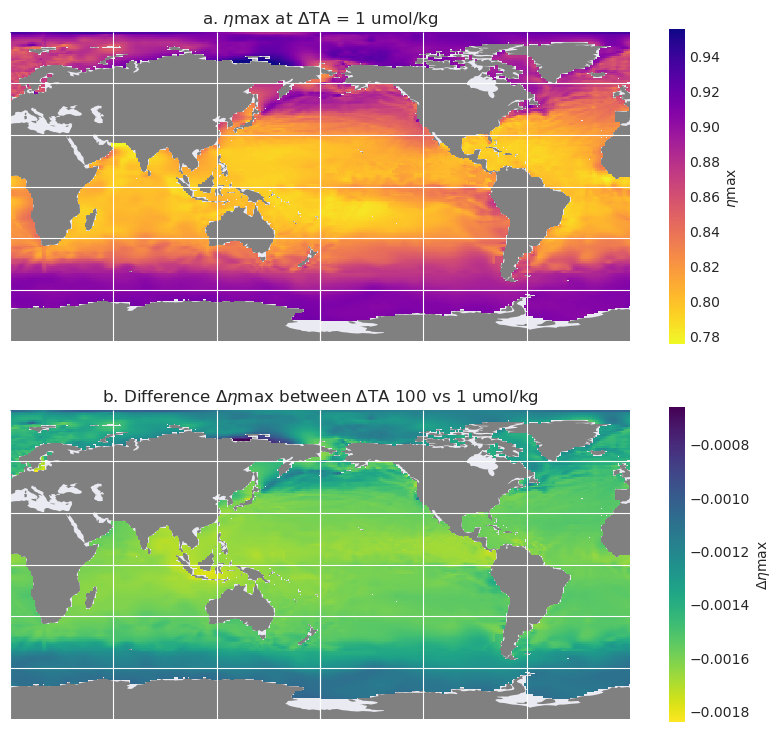

In [19]:
print('Plotting takes a few seconds, please wait ...')

fig, ax = plt.subplots(2, 1, figsize=(10, 9), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

lon = np.linspace(0.5, 359.5, 360)
lat = np.linspace(-89.5, 89.5, 180)
lon2d, lat2d = np.meshgrid(lon, lat)

# a. etamax assuming dTA = 1 umol/kg
plotdata = result_dTA1["etamax"]
ax[0].set_title(r'a. $\eta$max at $\Delta$TA = 1 umol/kg')
ax[0].add_feature(cfeature.LAND, facecolor='gray')
# ax[0].coastlines('10m', edgecolor='none', linewidth=0.5)
# ax[0].add_feature(cfeature.BORDERS)
ax[0].gridlines()
cmap0 = plt.get_cmap('plasma').reversed()
contour0 = ax[0].pcolor(lon, lat, plotdata, transform=ccrs.PlateCarree(), cmap=cmap0, vmin= 0.775, vmax=0.955)
cbar0 = plt.colorbar(contour0, orientation='vertical', pad=0.05)
cbar0.set_label(r'$\eta$max')

# b. Difference in etamax between dTA 100 vs 1 umol/kg
plotdata = etamax_difference
ax[1].set_title(r'b. Difference $\Delta\eta$max between $\Delta$TA 100 vs 1 umol/kg')
ax[1].add_feature(cfeature.LAND, facecolor='gray')
# ax[1].coastlines('10m', edgecolor='none', linewidth=0.5)
# ax[1].add_feature(cfeature.BORDERS, edgecolor='none')
ax[1].gridlines()
cmap1 = plt.get_cmap('viridis').reversed()
contour1 = ax[1].pcolor(lon, lat, plotdata, transform=ccrs.PlateCarree(), cmap=cmap1)  
cbar1 = plt.colorbar(contour1, orientation='vertical', pad=0.05)
cbar1.set_label(r'$\Delta\eta$max')
